# **Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti & Prof. Nicolò Navarin and Dr. Luca Pasa
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). 

#Requirements

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13 

#Imports

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing. 

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [ ]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
  img = to_tensor(img) #PIL to tensor + Scaling
  img = torch.mean(img, 0) #One channel averaged over the colors
  img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
  return img.to(torch.float32)

In [ ]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, noise_factor, device='cpu'):
    super().__init__()
    self.dataset = dataset
    self.nf = noise_factor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    x, _ = self.dataset[idx]
    x_noisy = x + self.nf*np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
    return (x.to(device), x_noisy.to(device))

In [ ]:
# Set niose factor for later
noise_factor = 0.1

# [TO COMPLETE] SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def svd_k(X, k):
  # k: sets the number of components to keep

  # Compute the matrix C
  C = torch.matmul(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = torch.linalg.svd(C)
  # Limit the number columns of U to k
  U_k = U[:,:k]
  return U_k

Now we create the dataset ready for the SVD:

In [ ]:
device = torch.device("cpu") #for SVD

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [ ]:
ENCODING_DIM = 256 #[TO COMPLETE]

U_k = svd_k(x_train, ENCODING_DIM)

x_training_svd = torch.matmul(x_train, U_k)
x_test_svd = torch.matmul(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = torch.matmul(x_training_svd, U_k.T)
x_test_reco = torch.matmul(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00149
Test mse: 0.00153


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

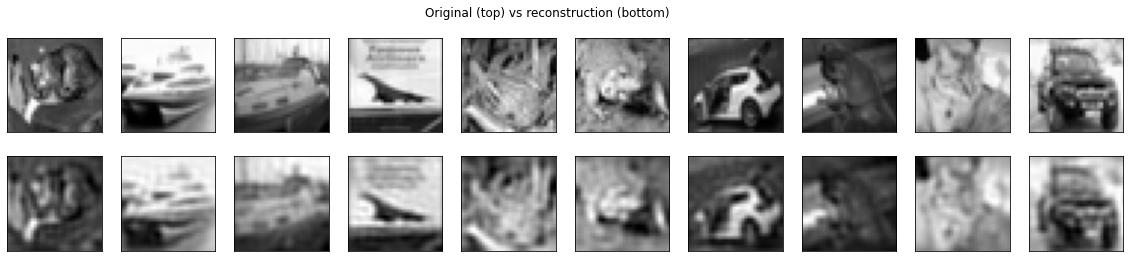

In [ ]:
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")


**[TO COMPLETE]**: What happens by varying the ENCODING_DIM?
 Test and discuss the results in a cell below.

`%STARTEXT`

**ANSWER**:

I tried different values and I noted that a higher **ENCODING_DIM** resulted in less compression but more information retained, while a lower **ENCODING_DIM** led to more compression but potentially more loss of information and lower reconstruction quality.

In addition, a higher **ENCODING_DIM** resulted in lower MSE values and better reconstruction fidelity, while a lower **ENCODING_DIM** led to higher MSE values and less accurate reconstruction.

It's a trade-off between compression and information preservation: very high **ENCODING_DIM** may result in overfitting or unnecessary complexity, while a very low **ENCODING_DIM** may result in significant information loss.

`%ENDEXT`

# [TO COMPLETE] Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.1 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. The `forward` method defines the forward pass of the Autoencoder.

In [ ]:
class Auto_Encoder(nn.Module):
  
  def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
    super().__init__()

    self.E_layers = nn.ModuleList()
    self.D_layers = nn.ModuleList()
    self.act_fun = act_fun
    activation_functions = {'linear': transforms.Lambda(lambda x: x),
                            'sigmoid': F.sigmoid,
                            'relu': F.relu,
                            'tanh': F.tanh,
                            'leaky_relu': F.leaky_relu}
    assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
    self.af = activation_functions[self.act_fun]

    for layer_idx in range(len(enc_layers)):
      if layer_idx == 0:  # first layer, from input to enc
        self.E_layers = self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
      else:  # hidden layers, depending on the input
        self.E_layers = self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

    if len(dec_layers) == 0:
      self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
    else:
      for layer_idx in range(len(dec_layers)):
        if layer_idx == 0:  # first layer, from enc to dec
          self.D_layers = self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
        else:  # hidden layers, depending on the input
          self.D_layers = self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))
    
      self.D_layers = self.D_layers.append(nn.Linear(dec_layers[-1], input_dim)) # final output layer
    
    self.apply(self._init_weights)
    
  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=.1)
        if module.bias is not None:
            module.bias.data.zero_()
  
  def forward(self, x):
    for layer in self.E_layers:
      x = self.af(layer(x))
    for layer in self.D_layers[:-1]:
      x = self.af(layer(x))
    if self.act_fun == 'linear':
      return self.D_layers[-1](x)
    else:
      return F.sigmoid(self.D_layers[-1](x)) #last act func is always sigmoid

**[TO COMPLETE]** Check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition. 

Try also to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [ ]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'linear'
lr = 0.005
epochs = 30 # Feel free to lower this to speed up the training times. Nevertheless, do not go below 25 epochs.

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, denoising=False):
  loss_train, loss_val = [], []
  for epoch in range(epochs):

    model.train()
    total_count_train, n_train_batches, total_loss_train = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_train):
      optimizer.zero_grad()
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss = criterion(x_rec, x)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_count_train += x.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    
    total_count_val, n_val_batches, total_loss_val = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (x, x_noisy) in enumerate(dataloader_val):
            if denoising:
              x_rec = model(x_noisy)
            else:
              x_rec = model(x)

            loss = criterion(x_rec, x)
            total_loss_val += loss
            total_count_val += x.size(0)
            n_val_batches += 1

    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
  return loss_train, loss_val

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.87470871 ---------------- Val_Acc: Val_Loss: 0.24823406
epoch: 2 -> Loss: 0.19870897 ---------------- Val_Acc: Val_Loss: 0.14750104
epoch: 3 -> Loss: 0.12334555 ---------------- Val_Acc: Val_Loss: 0.11132348
epoch: 4 -> Loss: 0.08842838 ---------------- Val_Acc: Val_Loss: 0.07929932
epoch: 5 -> Loss: 0.06787180 ---------------- Val_Acc: Val_Loss: 0.06180648
epoch: 6 -> Loss: 0.05400382 ---------------- Val_Acc: Val_Loss: 0.05079327
epoch: 7 -> Loss: 0.04433895 ---------------- Val_Acc: Val_Loss: 0.04130363
epoch: 8 -> Loss: 0.03687387 ---------------- Val_Acc: Val_Loss: 0.03498841
epoch: 9 -> Loss: 0.03248600 ---------------- Val_Acc: Val_Loss: 0.03016667
epoch: 10 -> Loss: 0.02733080 ---------------- Val_Acc: Val_Loss: 0.02666299
epoch: 11 -> Loss: 0.02400344 ---------------- Val_Acc: Val_Loss: 0.02365167
epoch: 12 -> Loss: 0.02188887 ---------------- Val_Acc: Val_Loss: 0.02095235
epoch: 13 -> Loss: 0.01939873 ---------------- Val_Acc: Val_Loss: 0.01935278
epoch: 1

In [ ]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

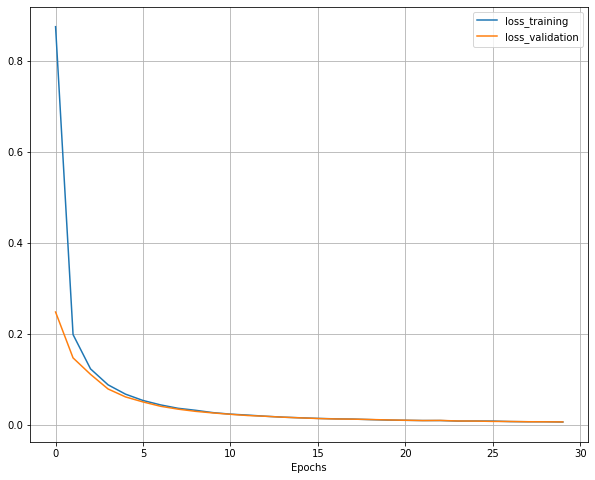

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
def test(model, dataloader_test=dataloader_test_AE, denoising=False): #dataloader_test_AE not train
  model.eval()
  total_count_test, n_batches_test, loss = 0, 0, 0
  for idx, (x, x_noisy) in enumerate(dataloader_test):
      if denoising:
        x_rec = model(x_noisy)
      else:
        x_rec = model(x)
      loss += criterion(x_rec, x)
      total_count_test += x.size(0)
      n_batches_test += 1
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}")

In [ ]:
test(Shallow_AE)

Test Loss: 0.00685243


In [ ]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
  if denoising:
    x = x_test_noisy.to(device)
  else:
    x = x_test.to(device)
  for layer in model.E_layers:
      x = model.af(layer(x))
  encoded_imgs = x


  y = encoded_imgs
  for layer in model.D_layers[:-1]:
      y = model.af(layer(y))
  if model.act_fun == 'linear':
    decoded_imgs = model.D_layers[-1](y)
  else:
    decoded_imgs = F.sigmoid(model.D_layers[-1](y))

  return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)

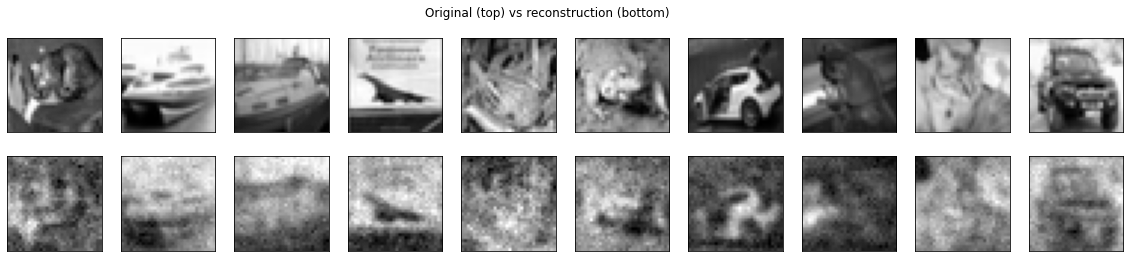

In [ ]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

`%STARTEXT`

**ANSWER**:

To make a fair comparison, in both the methods, I set the **ENCODING_DIM** (size of compressed version of input data) to 256 and I used the MSE as the loss function.

Both methods are limited to linear tranformations (they cannot capture nonlinear relationships). Moreover, when an autoencoder is linear and uses the MSE as the loss function, it learns to reconstruct the input data using a linear transformation that spans the principal components of the data: the linear autoencoder learns the same subspace as PCA.
For this reason, the results are similar in terms of MSE.

The difference between SVD and a shallow linear autoencoder lies in the learning aspect. A shallow linear autoencoder learns the encoding and decoding weights from the data using optimization techniques (gradient descent). On the other hand, SVD is an algebraic factorization method which provides a fixed decomposition based on the input matrix. In this way, the autoencoder can adapt to the specific characteristics of the data during training (only linear mappings), while SVD provides a more generalized decomposition.

In this case, SVD provides a slightly better MSE.

`%ENDTEXT`

# [TO COMPLETE] Shallow non-linear Autoencoder

**[TO COMPLETE]** Replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 30
# END



Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04202655 ---------------- Val_Acc: Val_Loss: 0.02757547
epoch: 2 -> Loss: 0.02292313 ---------------- Val_Acc: Val_Loss: 0.02363333
epoch: 3 -> Loss: 0.01805496 ---------------- Val_Acc: Val_Loss: 0.01752978
epoch: 4 -> Loss: 0.01603501 ---------------- Val_Acc: Val_Loss: 0.01389153
epoch: 5 -> Loss: 0.01334424 ---------------- Val_Acc: Val_Loss: 0.01353230
epoch: 6 -> Loss: 0.01239224 ---------------- Val_Acc: Val_Loss: 0.01137595
epoch: 7 -> Loss: 0.01120459 ---------------- Val_Acc: Val_Loss: 0.01141612
epoch: 8 -> Loss: 0.01066776 ---------------- Val_Acc: Val_Loss: 0.01096479
epoch: 9 -> Loss: 0.00996707 ---------------- Val_Acc: Val_Loss: 0.00998830
epoch: 10 -> Loss: 0.00980360 ---------------- Val_Acc: Val_Loss: 0.00934986
epoch: 11 -> Loss: 0.00912281 ---------------- Val_Acc: Val_Loss: 0.00963330
epoch: 12 -> Loss: 0.00881989 ---------------- Val_Acc: Val_Loss: 0.00925677
epoch: 13 -> Loss: 0.00864989 ---------------- Val_Acc: Val_Loss: 0.00825228
epoch: 1

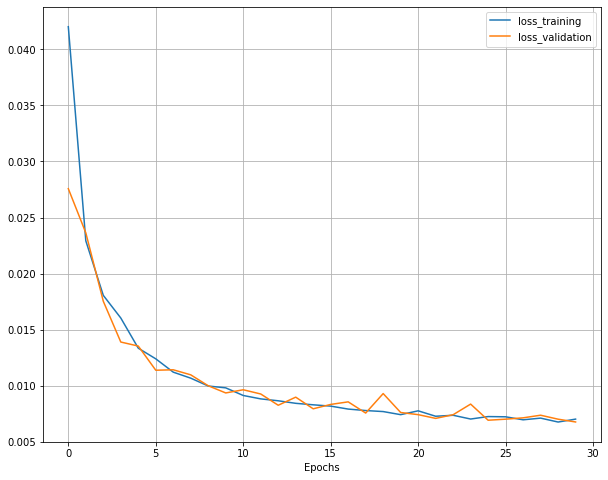

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(Shallow_non_AE)

Test Loss: 0.00671507


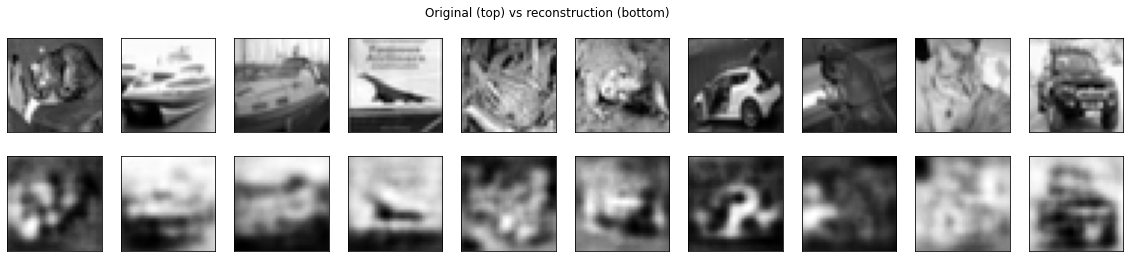

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Discuss the results you obtained with the activation functions you have tested and also motivate your choice. Compare your results to the ones obtained with the Shallow Linear Autoencoder.

`%STARTEXT`

**ANSWER**:

The results that I found suggest that, in this scenario, the Tanh and Sigmoid activation functions outperform ReLU and Leaky ReLU in terms of reconstruction quality, allowing them to capture more complex patterns and non-linear relationships more effectively. 

ReLU, in this case, seems to struggle in capturing the complex patterns and non-linear relationships: the high test loss (~0.0222) suggests that it is not able to effectively represent the data and reconstruct it with high fidelity.
This is probably due to the well-known "dead neurons" problem from which RELU suffers (when neuron's weights are initialized in such a way that the weighted sum of inputs is always negative).

Compared to ReLU, Leaky ReLU (which introduces a small negative slope for negative input values) has a lower test loss (0.0093) but it is still higher than the test loss of the Shallow Linear Autoencoder (~0.0063).
Thus, it may not be the most effective choice for capturing the non-linear relationships in the dataset. 

Tanh provides stronger non-linearity compared to ReLU and Leaky ReLU. In fact it squashes the input values between -1 and 1, allowing it to capture non-linearities with both positive and negative values. The lower test loss (~0.0082) indicates that Tanh is better at capturing the complex patterns and non-linear relationships in the dataset, resulting in improved reconstruction quality. Nevertheless, the curves of the training and validation loss are not smooth. In fact they present peaks (dramatic increases in loss) at certain epochs.

The test loss obtained with Sigmoid activation function is the lowest among all the tested activation functions and it has almost the same value of the Shallow Linear Autoencoder test loss. The curves of the training and validation loss are very smooth. The lower test loss suggests that Sigmoid is effective in capturing the complex patterns and non-linear relationships in the dataset (best reconstruction quality).


`%ENDTEXT`

# [TO COMPLETE] Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [IN_DIM//2, IN_DIM//4, IN_DIM//8] 
DEC_LAYERS = [IN_DIM//4, IN_DIM//2]
ACT_FUN = 'tanh'
lr = 0.001
epochs = 30
# END

DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
│    └─Linear: 2-2                       [512, 256]                131,328
│    └─Linear: 2-3                       [512, 128]                32,896
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-4                       [512, 256]                33,024
│    └─Linear: 2-5                       [512, 512]                131,584
│    └─Linear: 2-6                       [512, 1024]               525,312
Total params: 1,378,944
Trainable params: 1,378,944
Non-trainable params: 0
Total mult-adds (M): 706.02
Input size (MB): 2.10
Forward/backward pass size (MB): 11.01
Params size (MB): 5.52
Estimated Total Size (MB): 18.62

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [ ]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04416203 ---------------- Val_Acc: Val_Loss: 0.02955810
epoch: 2 -> Loss: 0.02541539 ---------------- Val_Acc: Val_Loss: 0.02559444
epoch: 3 -> Loss: 0.02124474 ---------------- Val_Acc: Val_Loss: 0.02445052
epoch: 4 -> Loss: 0.01980891 ---------------- Val_Acc: Val_Loss: 0.01890220
epoch: 5 -> Loss: 0.01793790 ---------------- Val_Acc: Val_Loss: 0.01751874
epoch: 6 -> Loss: 0.01672846 ---------------- Val_Acc: Val_Loss: 0.01713647
epoch: 7 -> Loss: 0.01601483 ---------------- Val_Acc: Val_Loss: 0.01622305
epoch: 8 -> Loss: 0.01546678 ---------------- Val_Acc: Val_Loss: 0.01538183
epoch: 9 -> Loss: 0.01471017 ---------------- Val_Acc: Val_Loss: 0.01663503
epoch: 10 -> Loss: 0.01451930 ---------------- Val_Acc: Val_Loss: 0.01452073
epoch: 11 -> Loss: 0.01406077 ---------------- Val_Acc: Val_Loss: 0.01441336
epoch: 12 -> Loss: 0.01371044 ---------------- Val_Acc: Val_Loss: 0.01435737
epoch: 13 -> Loss: 0.01331575 ---------------- Val_Acc: Val_Loss: 0.01365214
epoch: 1

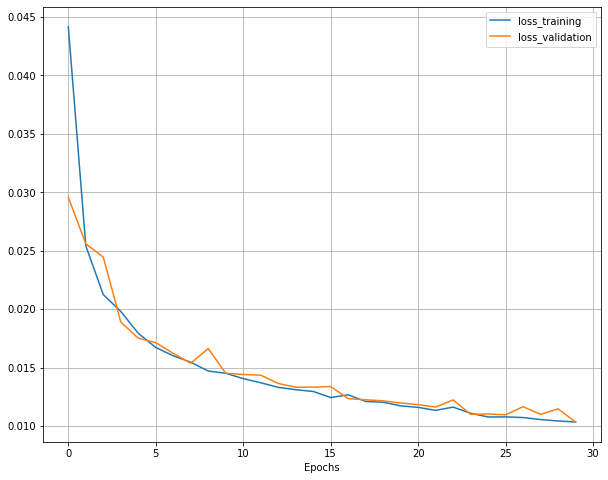

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(DEEP_non_AE)

Test Loss: 0.01027596


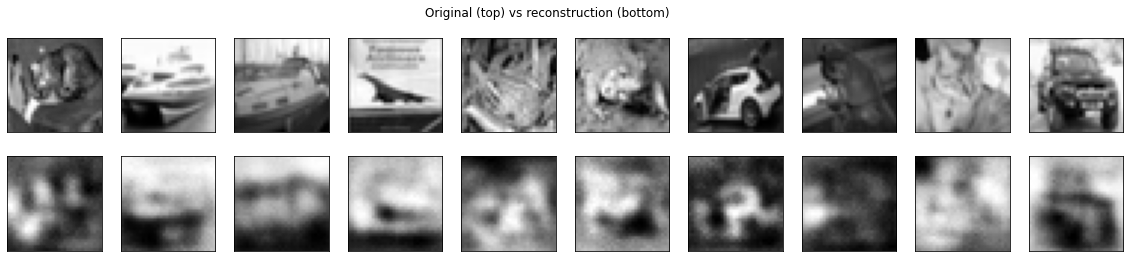

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

`%ENDCODE`

Write a short report of the results you obtained trying different hyperparameters configurations.

`%STARTEXT`

**ANSWER**:

I tried to set the following layers for the deep autoencoder:

ENC_LAYERS = [512, 256, 128, 64, 32]

DEC_LAYERS = [64, 128, 256, 512]

Then I tested the performance using different activation functions. 
The results, though, were very bad with respect to the Shallow Linear Autoencoder and the Shallow non-linear Autoencoder. 
The best result I obtained was ~0.019 using the leaky relu as activation function. The other activation functions made the learning process almost nonexistent.

Thus, I decided to lower the number of layers:

ENC_LAYERS = [512, 256, 128]

DEC_LAYERS = [256, 512]

The curves of the training and validation loss of different activation functions improved. 
Hence I tried to lower the learning rate.

With the learning rate set to 0.002 the results improved a little. On the other hand, lowering too much the learning rate (0.0005) didn't result in better performance. Knowing this, I performed some experiments with the learning rate equal to 0.001. At the end I was able to lower the test loss to ~0.010 using that learning rate and tanh as the activation function.

Possible reasons that might have led to a decrease in performance using deep nonlinear autoencoders:
- dealing with very small images in grayscale, making the encoder and decoder more complex will not necessarily result in a better reconstruction. At the end of the process of encoding, the input image has gone from 1024 to 128 units. In this way a lot of information is lost and the process of reconstruction is much more harder.
- vanishing/exploding gradients (networks with many layers are prone to this problem)
- overfitting (caused by the large number of layers and parameters)

`%ENDTEXT`

# [TO COMPLETE] Shallow Denoising Autoencoder

**[TO COMPLETE]** Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$. Write a short report of your findings below.

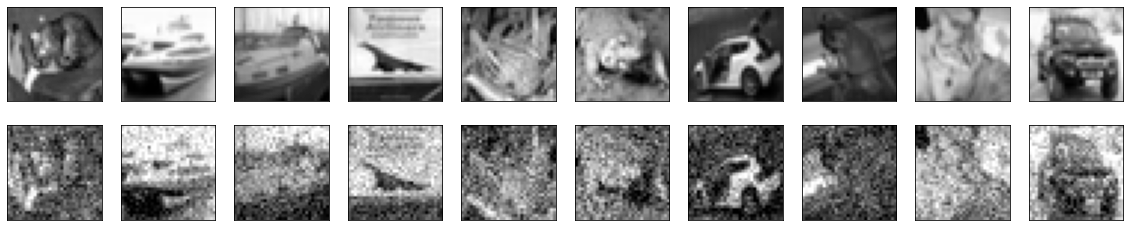

In [ ]:
plot_img(10, [x_test, x_test_noisy])

`%STARTCODE`

In [ ]:
# [TO COMPLETE]
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [512] 
DEC_LAYERS = [] 
ACT_FUN = 'sigmoid'
lr = 0.001
epochs = 30
# END

SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 512]                524,800
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               525,312
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
Total mult-adds (M): 537.66
Input size (MB): 2.10
Forward/backward pass size (MB): 6.29
Params size (MB): 4.20
Estimated Total Size (MB): 12.59

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [ ]:
noise_factor = 0.1
dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

start = timer()

# [TO COMPLETE]
# call the training function on noisy data
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising=True)#[TO COMPLETE]

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 0.04611452 ---------------- Val_Acc: Val_Loss: 0.03051901
epoch: 2 -> Loss: 0.02358850 ---------------- Val_Acc: Val_Loss: 0.01935112
epoch: 3 -> Loss: 0.01687903 ---------------- Val_Acc: Val_Loss: 0.01525876
epoch: 4 -> Loss: 0.01400345 ---------------- Val_Acc: Val_Loss: 0.01333014
epoch: 5 -> Loss: 0.01231638 ---------------- Val_Acc: Val_Loss: 0.01174171
epoch: 6 -> Loss: 0.01118022 ---------------- Val_Acc: Val_Loss: 0.01082478
epoch: 7 -> Loss: 0.01032861 ---------------- Val_Acc: Val_Loss: 0.01006131
epoch: 8 -> Loss: 0.00966683 ---------------- Val_Acc: Val_Loss: 0.00964216
epoch: 9 -> Loss: 0.00914440 ---------------- Val_Acc: Val_Loss: 0.00902621
epoch: 10 -> Loss: 0.00868974 ---------------- Val_Acc: Val_Loss: 0.00860834
epoch: 11 -> Loss: 0.00827281 ---------------- Val_Acc: Val_Loss: 0.00832125
epoch: 12 -> Loss: 0.00797431 ---------------- Val_Acc: Val_Loss: 0.00848931
epoch: 13 -> Loss: 0.00771776 ---------------- Val_Acc: Val_Loss: 0.00816143
epoch: 1

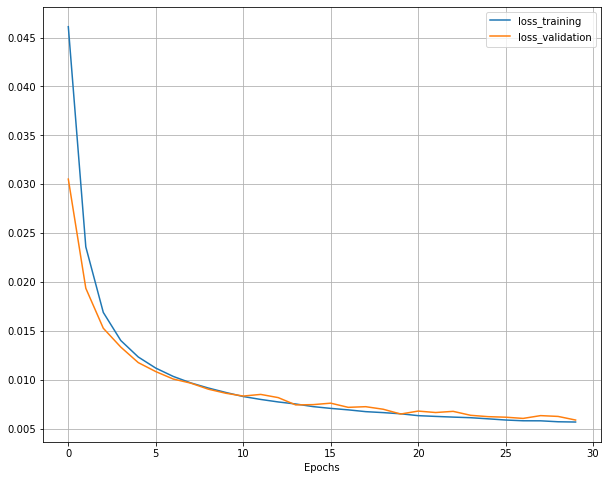

In [ ]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [ ]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.00581764


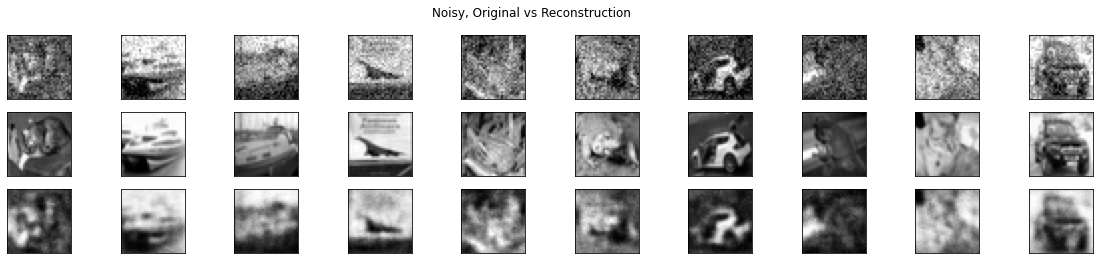

In [ ]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

`%ENDCODE`

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

`%STARTEXT`

**ANSWER**:
First of all I tried to find the best hyperparameter configuration while keeping the noise factor unchanged.

I compared the performance between a model with an encoding layer of 512 units and a model with an encoding layer of 256 units. I found out that 256 units are too few in this scenario and that 512 units lead to better performance. I subsequently lowered the learning rate to 0.001 to obtain a more stable convergence and an improved generalization. At this point I experimented different activations functions and I discovered that the Sigmoid leads to the best test loss (~0.0060).

To assess the impact of the noise factor on the model's denoising capability, I tested the previous (best) hyperparameter configuration on 3 different noise factors: 0.1, 0.3 and 0.5. The following are the respective test losses:
- ~0.0060
- ~0.0081
- ~0.0137

As expected, increasing the noise factor had a noticeable impact on the denoising capability of model. A lower noise factor resulted in better denoising performance, as the model could effectively remove the noise and reconstruct the original data with minimal distortion.
On the other hand, a higher noise factor introduced more significant noise into the input data, making it more challenging for the model to accurately denoise and reconstruct the original data. The reconstructed images exhibited more artifacts and distortions.

For the noise levels that I tried, the best hyperparameter configuration was:
- ENC_LAYERS = [512]
- DEC_LAYERS = []
- ACT_FUN = 'sigmoid'
- lr = 0.001
- epochs = 30

`%ENDTEXT`